# Classifying White Blood Cells

### Introduction

An important problem in blood diagnostics is classifying different types of blood cells. In this notebook, we will attempt to train a classifier to predict the type of a blood cell given a dyed picture of it.

### Data

We have 352 pictures of dyed white blood cells along with labels of what type of blood cell they are. Below is an example of each of the types of blood cells in our dataset.

##### Basophil
![Basophil](Basophil.jpg)

#### Eosinophil
![Eosinophil](Eosinophil.jpg)

#### Lymphocyte
![Lymphocyte](Lymphocyte.jpg)

#### Monocyte
![Monocyte](Monocyte.jpg)

#### Neutrophil
![Neutrophil](Neutrophil.jpg)

### Methodology

We use a simple LeNet architecture trained on 281 training samples with image augmentation. Our augmentation techniques include rotations, shifts, and zooms.

We validate our results against 71 samples.

### Results

We obtain an accuracy of 98.6% on this validation set with the following confusion matrix:

![Confusion Matrix](confusion_matrix.png)


# Code

In [1]:
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import scipy
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt


Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
epochs = 2
BASE_DIR = '../'
batch_size = 32

In [3]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [4]:
model = get_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 38, 32)        0         
__________

In [5]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [6]:
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [7]:
model = get_model()

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

Train on 15873 samples, validate on 3969 samples
Epoch 1/2
15873/15873 [==============================] - 47s - loss: 0.6416 - acc: 0.6320 - val_loss: 0.9020 - val_acc: 0.2771
Epoch 2/2
15873/15873 [==============================] - 46s - loss: 0.4683 - acc: 0.7831 - val_loss: 0.0938 - val_acc: 1.0000


In [8]:
# saving weight file
model.save_weights(os.path.join(os.getcwd(),'binary_model.h5'))

# Learning Curve

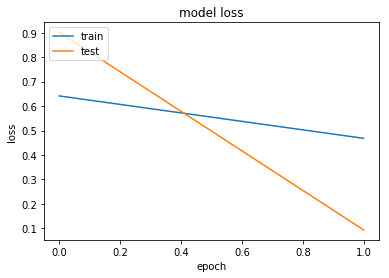

In [9]:
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(os.path.join(os.getcwd(),'loss_curve.png'))

plot_learning_curve(history)

# Accuracy

In [10]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))
stats = {}
stats['accuracy_score'] = accuracy_score(y_test, y_pred)
stats_filename = os.path.join(os.getcwd(),'stats.json')
with open(stats_filename, 'wb') as f:
    f.write(json.dumps(stats))
print stats

Predicting on test data
{'accuracy_score': 0.88732394366197187}


# Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[  8  32]
 [  0 244]]


# Images Misclassified

In [12]:
false_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))

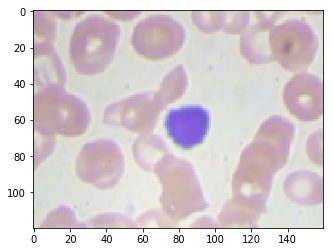

In [13]:
img = X_test[false_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Mononuclear Cells Classified Correctly

In [14]:
true_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 1))

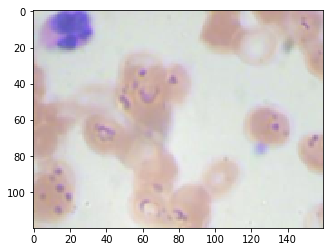

In [15]:
img = X_test[true_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

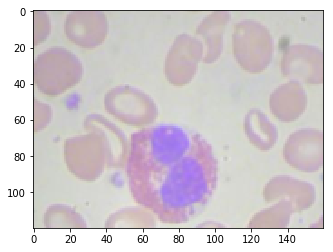

In [16]:
img = X_test[true_positive_mononuclear[5]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

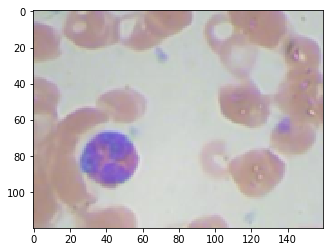

In [17]:
img = X_test[true_positive_mononuclear[8]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Polynuclear Cells Classified Correctly

In [22]:
true_positive_polynuclear = np.intersect1d(np.where(y_pred == 0), np.where(y_test == 0))

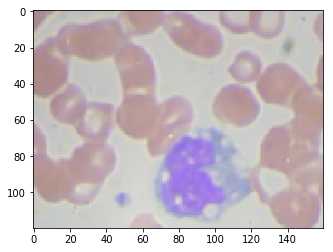

In [25]:
img = X_test[true_positive_polynuclear[5]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

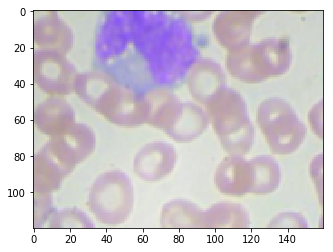

In [26]:
img = X_test[true_positive_polynuclear[4]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

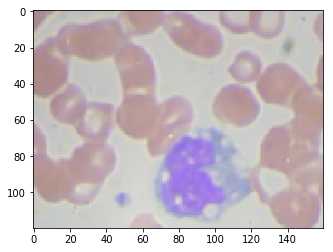

In [27]:
img = X_test[true_positive_polynuclear[2]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))